# CPSC 536M - Homework 2
Emma Hansen and Naomi Graham

October 2020

In [340]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra, Colors, DSP,ToeplitzMatrices, SparseArrays, Wavelets, LazySets
using PyPlot, FFTW, ForwardDiff

In [394]:
# Functions
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

function linesearch(grad_f,s,d)
    #alpha_upper0 = 1
    #alpha_lower0 = 0
    alpha_mid = 0.5
    alpha_range = 0.5
    stop = 50
    alpha_storage = zeros(stop+1)
    alpha_storage[1] = alpha_mid
    
    for i=1:stop
        val_mid = dot(-grad_f, alpha_mid * s + (1-alpha_mid) * d) / (norm(grad_f)*norm(alpha_mid * s + (1-alpha_mid) * d))
        alpha_upper = alpha_mid + (1/2)*alpha_range
        alpha_lower = alpha_mid - (1/2)*alpha_range
        
        val_upper = dot(-grad_f, alpha_upper * s + (1-alpha_upper) * d) / (norm(grad_f)*norm(alpha_upper * s + (1-alpha_upper) * d))
        val_lower = dot(-grad_f, alpha_lower * s + (1-alpha_lower) * d) / (norm(grad_f)*norm(alpha_lower * s + (1-alpha_lower) * d))
        
        if val_upper > val_mid # note: I think something is wrong with this criteria...
            alpha_mid = deepcopy(alpha_upper)
        elseif val_lower > val_mid
            alpha_mid = deepcopy(alpha_lower)
        end
        
#         if val_upper > val_mid # note: something IS wrong with this one...
#             alpha_lower0 = alpha_mid
#             alpha_mid = alpha_upper0
            
#         elseif val_lower > val_mid
#             alpha_upper0 = alpha_mid
#             alpha_mid = alpha_lower0
            
#         else
#             alpha_upper0 = alpha_upper1
#             alpha_lower0 = alpha_lower1
#         end
        
        alpha_range = (1/2) * alpha_range
        alpha_storage[i+1] = deepcopy(alpha_mid)
    end
    return alpha_mid, alpha_storage
end
    
    

# to solve <s,grad(f)>
function get_s(D,grad_f) # works if you know the atoms
    n,m = size(D)
    stop = 100
    
    IP = ((-grad_f)' * D) ./ (norm(grad_f) .* 1)
    ind_max = argmax(IP)[2]
    s0 = D[:,ind_max]
    val0 = maximum(IP)

    IP_new = deepcopy(IP)
    IP_new[ind_max] = -IP[ind_max]
    
    max_inds = zeros((m,1))
    max_inds[1] = ind_max
    
    for j=2:m
        ind_max = argmax(IP_new)[2]
        d = D[:,ind_max]
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha * s0 + (1-alpha) * d
        
        val1 = (s1' * (-grad_f))[1]
        
        if val1 < val0
            return s0,max_inds
            break
        end
        
        s0 = s1
        IP_new[ind_max] = -IP[ind_max]
        val0 = val1
        max_inds[j] = ind_max
    end
end
        
function get_s(grad_f,tau)
    eps = 0.01
    n = size(grad_f)[1]
    s0 = rand(n)
    s0 = tau .* (s0 ./ sum(x0))
    
    while (s0' * (-grad_f)) > eps
        d = rand(n)
        d = tau .* (d ./ sum(d))
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha .* s0 + (1-alpha) .* d
        
    end
    
end


# Frank-Wolfe
function frank_wolfe(tau,f,f_grad,K,x0_wav,wav)
    # x0 is a vector
    n = size(x0_wav)[1]
    #x0 = D[:,rand(1:m,(1))]
    
    for k=1:K
        
#         grad_f = gradient(y -> f(y),Array(x0)[:,1])
        
        x0 = idwt(x0_wav, wav, 3)
        grad_f = f_grad(x0)
        
        #s, = get_s(D,grad_f[1])
        
        ind_max = argmax(grad_f)
        s = -tau * sign(grad_f[ind_max])* I(n)[:,ind_max] # from http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/23-cond-grad-scribed.pdf
        
        gamma = 2 / (2+k)
        x1_wav = ((1-gamma) .* x0_wav) + (gamma .* s)
        x0_wav = deepcopy(x1_wav)
        #x_history[:,k+1] = x0
        
        if mod(k,100)==1
            print("k is: ")
            println(k)
            print("max of x is:")
            println(maximum(x0_wav))
            print("max of s is: ")
            println(maximum(s))
            print("value is: ")
            println(f(idwt(x0_wav, wav, 3)))
        end
    end
    return x0_wav
end

function ConvolutionMatrix(Kernel,N)
    # N is length of image to be convolved with (must be a square image)
    toeplitzrow = hcat(Kernel[1,:]',zeros(1,N-size(Kernel)[1]))
    for i=2:size(Kernel)[1]
        toeplitzrow = hcat(toeplitzrow,Kernel[i,:]',zeros(1,N-size(Kernel)[1]))
    end
    l = size(toeplitzrow)[2]
    toeplitzrow = hcat(toeplitzrow,zeros(1,N^2-l))

    toeplitz = Circulant(toeplitzrow')'
    
    return sparse(toeplitz)
end

ConvolutionMatrix (generic function with 1 method)

In [3]:
# Good to know functions
x = [1,2,3,4]

function normsquared(x)
    return sum(x .^ 2)
end

normsquared(x)
gradient(y -> normsquared(y),x)

([2, 4, 6, 8],)

## Testing linesearch function
The non-random test case is based on the following figure:

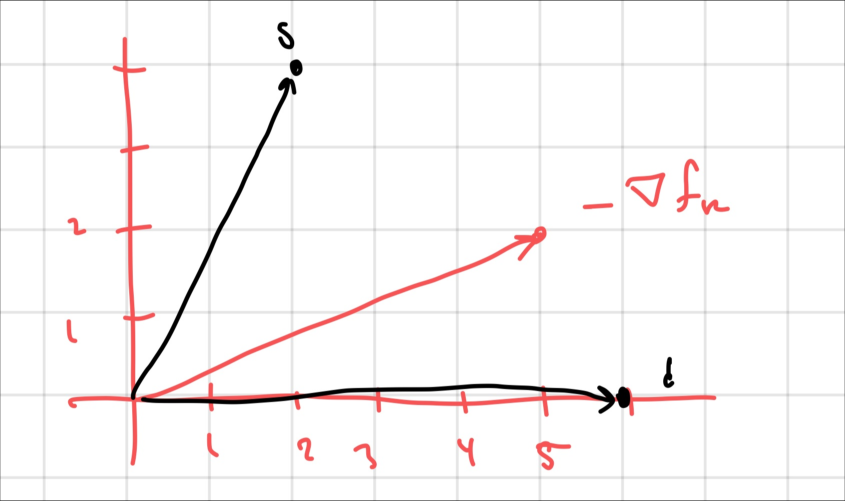

In [4]:
linesearch_file = "linesearch_example.jpg"
linesearch_ex = load(linesearch_file)

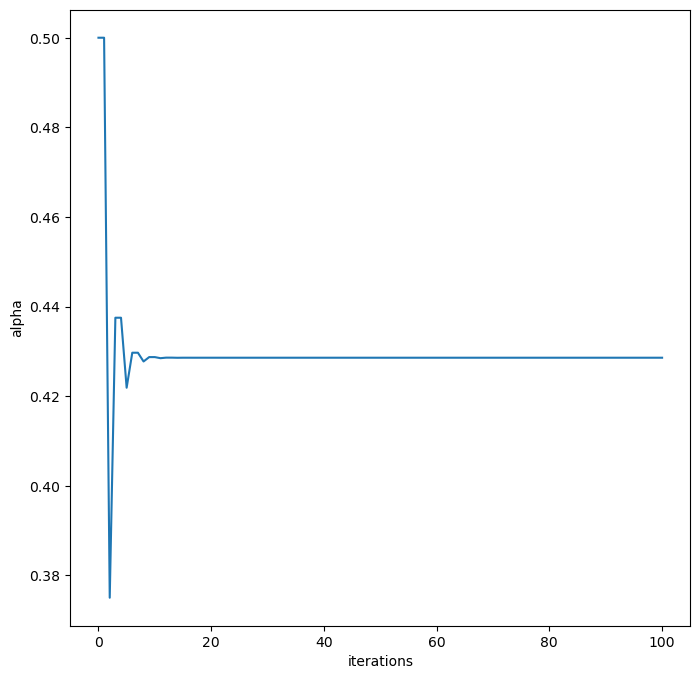

In [5]:
# grad_f = 2 .* (rand(Float16,(5,1)) .- 0.5) 
# s = 2 .* (rand(Float16,(5,1)) .- 0.5)
# d = 2 .* (rand(Float16,(5,1)) .- 0.5)
# print([grad_f,s,d])

grad_f = [-5,-2]
s = [2,4]
d = [6,0]

alpha_mid,alpha_storage = linesearch(grad_f,s,d);

fig = figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(alpha_storage);
ax1.set_ylabel("alpha");
ax1.set_xlabel("iterations");

## Testing argmin function
The test for the argmin function is the following example.
NOTE: in the figure, what's listed as $\nabla f$ should actually be labelled $-\nabla f$.

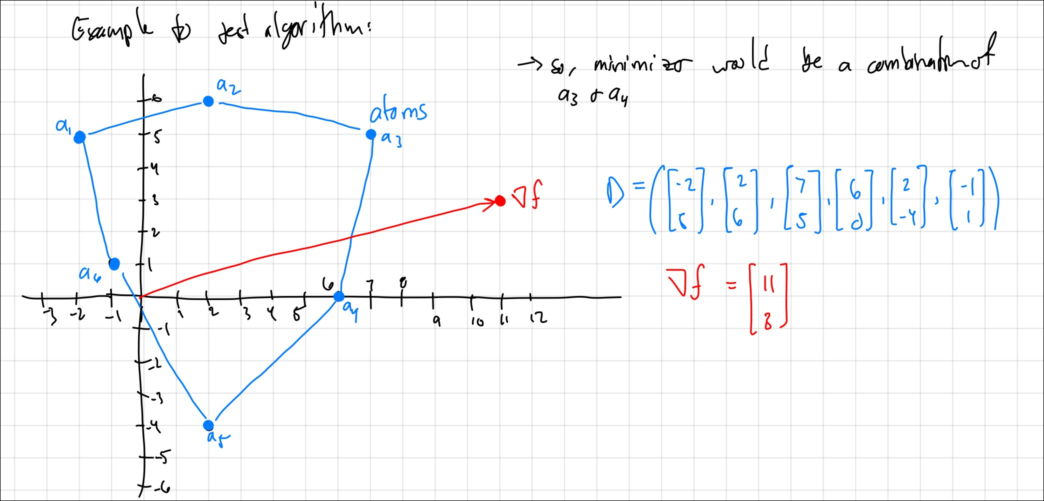

In [6]:
argmin_file = "argmin_example.jpg"
argmin_ex = load(argmin_file)

In [94]:
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
grad_f = [-11;-3];

s,max_inds = get_s(D,grad_f)
print("argmin is: ")
println(s)
print("the atoms used are:")
print(max_inds[max_inds .> 0])

argmin is: [6.346153855352895, 1.7307692767644767]
the atoms used are:[4.0, 3.0]

## Testing Frank-Wolfe

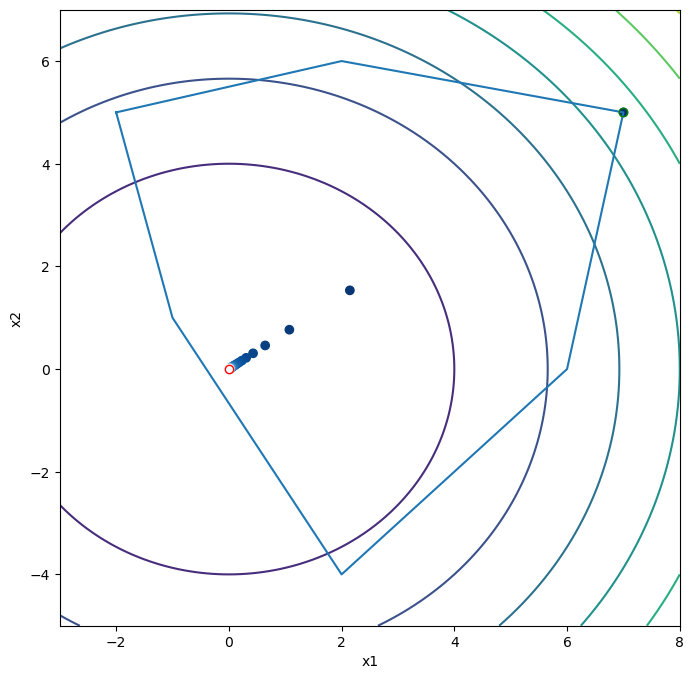

In [21]:
function func(x)
    return (1/2) * sum(x .^ 2)
end

D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
K = 50
x_history = frank_wolfe(D,func,K) # does this weird thing where it overwrites D? and outputs that?? I don't understand

# Plotting
X,Y = meshgrid(-3:0.1:8,-5:0.1:7)

fig = figure(figsize=(8,8))
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])

ax1 = fig.add_subplot(1, 1, 1)
ax1.contour(X,Y,reshape([ func(vcat(X[:]',Y[:]')[:,i]) for i in 1:size(X[:])[1] ],size(X)) ) 
ax1.plot(vcat(D[1,:],D[1,1]),vcat(D[2,:],D[2,1]))
ax1.scatter(x_history[1,:],x_history[2,:],c=[1:K+1],cmap="Blues_r")
ax1.plot(x_history[1,1],x_history[2,1],markerfacecolor="none",markeredgecolor="g",linestyle="none",marker="o")
ax1.plot(x_history[1,end],x_history[2,end],markerfacecolor="none",markeredgecolor="r",linestyle="none",marker="o")
ax1.set_ylabel("x2");
ax1.set_xlabel("x1");

In [112]:
D[1,end]

-1

## Actual project
### Prepare Images

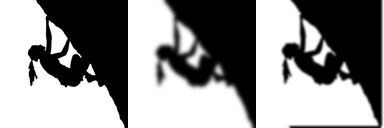

In [284]:
# Clear image
original_path = "smaller_climber128.jpg"
original = load(original_path)
original_grey = Gray.(original)
original_array = convert(Array{Float64}, original_grey)

n, = size(original_array)

# Blurring in photoshop
blurry_path = "smaller_climber_blurry.jpg"
blurry1 = load(blurry_path)
blurry_grey = Gray.(blurry1)
blurry1_array = convert(Array{Float64}, blurry_grey)

# Blurring in Julia
#Kernel = (1/16) .* [1 2 1;2 4 2;1 2 1] # gaussian blur 3x3 from https://en.wikipedia.org/wiki/Kernel_(image_processing)
Kernel = (1/256) .* [1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1]
m = size(Kernel)[1]
conv_matrix = ConvolutionMatrix(Kernel,n)
blurry_array = reshape(conv_matrix * original_array[:],size(original_array))


mosaicview(original, blurry1, Gray.(blurry_array); nrow=1)

### Frank-Wolfe Algorithm

In [400]:
function objective(X,R,wav,B)
#     X = idwt(X_wav, wav, 3) # commented out since derivative doesn't like the transform to occur in the objective...
    return (1/2) * sum(( (R * X[:]) - B[:]) .^ 2)
end

function obejctive_gradient(X_vec,R,B_vec,wav)
    return dwt((R' * R * X_vec) - (R' * B_vec), wav, 3)
end

wt = wavelet(WT.haar) # define wavelet to use in transform
wt = WT.scale(wt, 1.1) # 1/sqrt(2) scales output to be between 0 and 1 - useful? idk

K = 5001 # frank-wolfe iterations

BLURRY = blurry_array
X0_wav = dwt(BLURRY,wt,3) # make initial condition the wavelet transform of blurry matrix
tau = 1000 # make tau the 1-norm of the wavelet transform of blurry matrix
W = idwt(I(n), wt, 3)

f = (y -> objective(y,conv_matrix,wt,BLURRY)) # set objective function
f_grad = (y -> obejctive_gradient(y,conv_matrix,BLURRY[:],wt))
X_wav_sol = frank_wolfe(tau,f,f_grad,K,X0_wav[:],wt); # call frank-wolfe
# X_wav_sol = frank_wolfe(tau,f,K,X0_wav,wt)
X_sol = idwt(X_wav_sol, wt, 3); # inverse wavelet transform to bring back to the image domain

k is: 1
max of x is:4.724162666666673
max of s is: 0.0
value is: 94702.2662335948
k is: 101
max of x is:0.0026979798210546393
max of s is: 0.0
value is: 4656.4330942222505
k is: 201
max of x is:0.0006912397210164372
max of s is: 0.0
value is: 4450.81244376999
k is: 301
max of x is:0.0003097608462833042
max of s is: 0.0
value is: 4376.325913732163
k is: 401
max of x is:0.00017496250756144846
max of s is: 0.0
value is: 4324.217246642002
k is: 501
max of x is:0.00011225466325552669
max of s is: 0.0
value is: 4294.1687474304235
k is: 601
max of x is:7.808404268799975e-5
max of s is: 0.0
value is: 4274.164775210139
k is: 701
max of x is:5.743592985698251e-5
max of s is: 0.0
value is: 4266.573209492504
k is: 801
max of x is:4.4013527824274976e-5
max of s is: 0.0
value is: 4261.972667235105
k is: 901
max of x is:3.480020527780032e-5
max of s is: 0.0
value is: 4256.85229268727
k is: 1001
max of x is:2.8203787838082577e-5
max of s is: 0.0
value is: 4251.052374688654
k is: 1101
max of x is:2.331

### Print Result

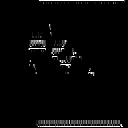

In [401]:
X = reshape(X_sol,size(blurry_array))
Gray.(X)